In [13]:
#!/usr/bin/python -tt
# -*- coding: utf-8 -*-
"""
Created on Sat May 27 12:46:25 2017

@author: ehsanamid
"""

# -*- coding: utf-8 -*-
"""
Created on Fri May 26 12:17:14 2017

@author: ehsanamid
"""

import sys
from sklearn.neighbors import NearestNeighbors as knn
from sklearn.decomposition import TruncatedSVD
import numpy as np

def generate_triplets(X, kin=50, kout = 10, kr = 5, weight_adj=False, random_triplets=True):
    num_extra = np.maximum(kin+50, 60) # look up more neighbors
    n = X.shape[0]
    nbrs = knn(n_neighbors= num_extra + 1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
#    sig = distances[:,10]
    sig = np.maximum(np.mean(distances[:, 10:20], axis=1), 1e-20) # scale parameter
    P = np.exp(-distances**2/np.reshape(sig[indices.flatten()],[n, num_extra + 1])/sig[:,np.newaxis])
    sort_indices = np.argsort(-P, axis = 1) # actual neighbors
    
    triplets = np.zeros([n * kin * kout, 3])
    weights = np.zeros(n * kin * kout)
    
    cnt = 0
    for i in range(n):
        for j in range(kin):
            sim = indices[i,sort_indices[i,j+1]]
            p_sim = P[i,sort_indices[i,j+1]]
            rem = indices[i,sort_indices[i,:j+2]].tolist()
            l = 0
            while (l < kout):
                out = np.random.choice(n)
                if out not in rem:
                    triplets[cnt,:] = [i, sim, out]
                    p_out = np.exp(-np.sum((X[i,:]-X[out,:])**2)/(sig[i] * sig[out]))
                    if p_out < 1e-20:
                        p_out = 1e-20
                    weights[cnt] = p_sim/p_out
                    rem.append(out)
                    l += 1
                    cnt += 1
        if ((i+1) % 10000) == 0:
            print('Genareted triplets %d out of %d' % (i+1, n))
    if random_triplets:
        kr = 5
        triplets_rand = np.zeros([n * kr, 3])
        weights_rand = np.zeros(n * kr)
        for i in range(n):
            cnt = 0
            while cnt < kr:
                sim = np.random.choice(n)
                if sim == i:
                    continue
                out = np.random.choice(n)
                if out == i or out == sim:
                    continue
                p_sim = np.exp(-np.sum((X[i,:]-X[sim,:])**2)/(sig[i] * sig[sim]))
                if p_sim < 1e-20:
                    p_sim = 1e-20
                p_out = np.exp(-np.sum((X[i,:]-X[out,:])**2)/(sig[i] * sig[out]))
                if p_out < 1e-20:
                    p_out = 1e-20
                if p_sim < p_out:
                    sim, out = out, sim
                    p_sim, p_out = p_out, p_sim
                triplets_rand[i * kr + cnt,:] = [i, sim, out]
                weights_rand[i * kr + cnt] = p_sim/p_out
                cnt += 1
            if ((i+1) % 10000) == 0:
                print('Genareted random triplets %d out of %d' % (i+1, n))
        triplets = np.vstack((triplets, triplets_rand))
        weights = np.hstack((weights, weights_rand))
    triplets = triplets[~np.isnan(weights),:]
    weights = weights[~np.isnan(weights)]
    weights /= np.max(weights)
    weights += 0.0001
    if weight_adj:
        weights = np.log(1 + 50 * weights)
        weights /= np.max(weights)
    return (triplets.astype(int), weights.flatten())
        
def trimap_grad(Y, triplets, weights):
    n, dim = Y.shape
    grad = np.zeros([n, dim])
    y_ij = Y[triplets[:,0],:] - Y[triplets[:,1],:]
    y_ik = Y[triplets[:,0],:] - Y[triplets[:,2],:]
    d_ij = 1 + np.sum(y_ij**2,axis=-1)
    d_ik = 1 + np.sum(y_ik**2,axis=-1)
    num_viol = np.sum(d_ij > d_ik)
    denom = (d_ij + d_ik)**2
    loss = weights.dot(d_ij/(d_ij + d_ik))
    gs = 2 * y_ij * (d_ik/denom * weights)[:,np.newaxis]
    go = 2 * y_ik * (d_ij/denom * weights)[:,np.newaxis]
    for i in range(dim):
        grad[:,i] += np.bincount(triplets[:,0], weights= gs[:,i] - go[:,i])
        grad[:,i] += np.bincount(triplets[:,1], weights = -gs[:,i])
        grad[:,i] += np.bincount(triplets[:,2], weights = go[:,i])
    return loss, grad, num_viol
    

def trimap(X, num_dims = 2, num_neighbs = 50, num_out = 10, num_rand=5, eta = 1000.0, Yinit=[]):
    n, dim = X.shape
    print("running TriMap on %d points with dimension %d" % (n,dim))
    print("PLEASE DO NOT DISTRIBUTE THE CODE!")
    X -= np.min(X)
    X /= np.max(X)
    X -= np.mean(X,axis=0)
    if dim > 50:
#        pca = PCA(n_components=50)
#        pca.fit(X)
#        X = np.dot(X, pca.components_.transpose())
#        cov = np.dot(X.transpose(), X)
#        pca = PCA(n_components=50)
#        pca.fit(cov)
#        X = np.dot(X, pca.components_.transpose())
        X = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)
    if np.size(Yinit) > 0:
        Y = Yinit
    else:
        Y = np.random.normal(size=[n, num_dims]) * 0.0001
    C = np.inf
    best_C = np.inf
    best_Y = Y
    tol = 1e-7
    num_iter = 2000
#    eta = 500.0 # learning rate
    
    triplets, weights = generate_triplets(X, num_neighbs, num_out, num_rand)
    num_triplets = float(triplets.shape[0])
    
    print('starting')
    for itr in range(num_iter):
        old_C = C
        C, grad, num_viol = trimap_grad(Y, triplets, weights)
        
        # maintain the best answer
        if C < best_C:
            best_C = C
            best_Y = Y
            
        # update Y
        Y -= (eta/num_triplets * n) * grad;
        
        # update the learning rate
        if old_C > C + tol:
            eta = eta * 1.01
        else:
            eta = eta * 0.5
        
        if (itr+1) % 100 == 0:
            print('Iteration: %4d, Loss: %3.3f, Violated triplets: %0.4f' %
                  (itr+1, C, float(num_viol)/num_triplets))
    return best_Y

running TriMap on 2500 points with dimension 784
PLEASE DO NOT DISTRIBUTE THE CODE!
starting
Iteration:  100, Loss: 30.302, Violated triplets: 0.0812
Iteration:  200, Loss: 20.298, Violated triplets: 0.0678
Iteration:  300, Loss: 16.302, Violated triplets: 0.0641
Iteration:  400, Loss: 14.316, Violated triplets: 0.0620
Iteration:  500, Loss: 13.365, Violated triplets: 0.0617
Iteration:  600, Loss: 13.065, Violated triplets: 0.0617
Iteration:  700, Loss: 12.731, Violated triplets: 0.0617
Iteration:  800, Loss: 12.572, Violated triplets: 0.0618
Iteration:  900, Loss: 12.414, Violated triplets: 0.0618
Iteration: 1000, Loss: 12.278, Violated triplets: 0.0618
Iteration: 1100, Loss: 12.190, Violated triplets: 0.0617
Iteration: 1200, Loss: 12.085, Violated triplets: 0.0615
Iteration: 1300, Loss: 12.006, Violated triplets: 0.0614
Iteration: 1400, Loss: 11.953, Violated triplets: 0.0614
Iteration: 1500, Loss: 11.897, Violated triplets: 0.0616
Iteration: 1600, Loss: 11.854, Violated triplets: 0.

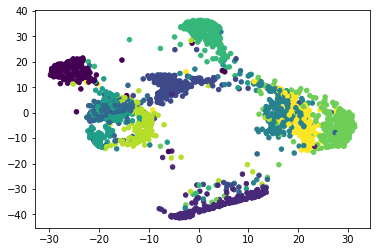

In [15]:
import matplotlib.pyplot as plt

X = np.loadtxt('data/mnist2500_X.txt')
labels = np.loadtxt('data/mnist2500_labels.txt')
Y = trimap(X, 2, 50, 10, 5, 1000)
plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
plt.show()
# np.savetxt('result_2D.txt',Y)